<a href="https://colab.research.google.com/github/quocthang0507/tensorflow_text/blob/main/text_classification_rnn_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Setup input pipeline

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGL6YU5/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGL6YU5/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGL6YU5/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'There are some films that every Horror fan owes himself (or herself) to see, and Emilio Miraglia\'s "La Dama Rossa Uccide Sette Volte" aka. "The Red Queen Kills Seven Times" (1972) is definitely one of them. With Gialli and Gothic Tales being my two favorite sub-genres in Horror, I was looking forward to seeing this film for quite a while, and even though my expectations were high, this masterpiece surpassed my greatest hopes. Miraglia\'s earlier Giallo, "The Night Evelyn Came Out of the Grave" (1971) was already a creepy and highly atmospheric film which successfully mixed Giallo with Gothic Horror, but it couldn\'t possibly compare to this instant personal favorite. "The Red Queen Kills Seven Times" is, hands down, one of the most unique and overwhelming Italian Horror films ever made, and no lover of the genre could possibly consider missing it. An incredibly mesmerizing Giallo with strong Gothic elements, "The Red Queen" delivers everything one could hope for in either s

# Create the text encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 48,  24,  47, ...,   0,   0,   0],
       [ 10, 153, 344, ...,   0,   0,   0],
       [  1,  70,   6, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'There are some films that every Horror fan owes himself (or herself) to see, and Emilio Miraglia\'s "La Dama Rossa Uccide Sette Volte" aka. "The Red Queen Kills Seven Times" (1972) is definitely one of them. With Gialli and Gothic Tales being my two favorite sub-genres in Horror, I was looking forward to seeing this film for quite a while, and even though my expectations were high, this masterpiece surpassed my greatest hopes. Miraglia\'s earlier Giallo, "The Night Evelyn Came Out of the Grave" (1971) was already a creepy and highly atmospheric film which successfully mixed Giallo with Gothic Horror, but it couldn\'t possibly compare to this instant personal favorite. "The Red Queen Kills Seven Times" is, hands down, one of the most unique and overwhelming Italian Horror films ever made, and no lover of the genre could possibly consider missing it. An incredibly mesmerizing Giallo with strong Gothic elements, "The Red Queen" delivers everything one could hope for in either

# Create the model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.01307263]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.01307263]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 838s 2s/step - loss: 0.6397 - accuracy: 0.5749 - val_loss: 0.4762 - val_accuracy: 0.7318
Epoch 2/10
391/391 [==============================] - 842s 2s/step - loss: 0.4055 - accuracy: 0.8098 - val_loss: 0.3920 - val_accuracy: 0.8219
Epoch 3/10
391/391 [==============================] - 842s 2s/step - loss: 0.3461 - accuracy: 0.8471 - val_loss: 0.3436 - val_accuracy: 0.8417
Epoch 4/10
391/391 [==============================] - 848s 2s/step - loss: 0.3234 - accuracy: 0.8601 - val_loss: 0.3297 - val_accuracy: 0.8510
Epoch 5/10
391/391 [==============================] - 831s 2s/step - loss: 0.3151 - accuracy: 0.8637 - val_loss: 0.3246 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 827s 2s/step - loss: 0.3068 - accuracy: 0.8694 - val_loss: 0.3196 - val_accuracy: 0.8625
Epoch 7/10
391/391 [==============================] - 826s 2s/step - loss: 0.3017 - accuracy: 0.8720 - val_loss: 0.3191 - val_accuracy: 0.8599

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 166s 424ms/step - loss: 0.3200 - accuracy: 0.8643
Test Loss: 0.31999334692955017
Test Accuracy: 0.8643199801445007


(0.0, 0.6567945018410682)

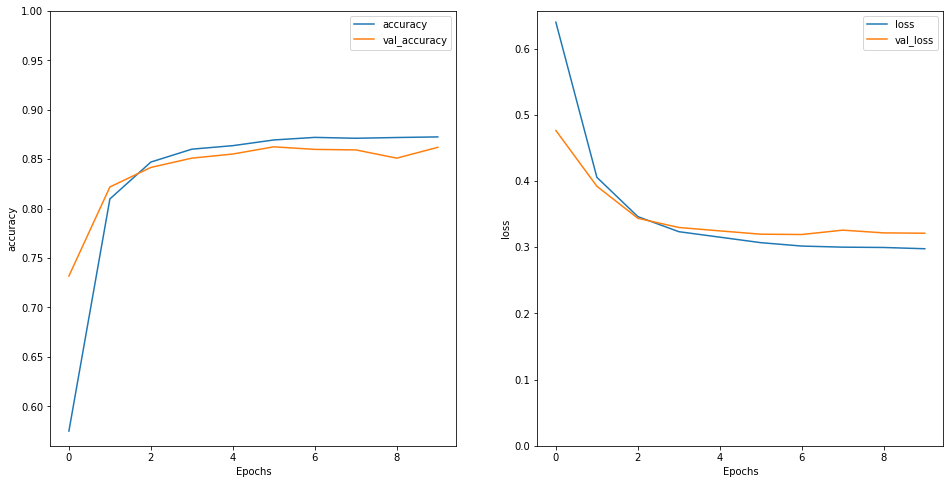

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

# Stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1490s 4s/step - loss: 0.6513 - accuracy: 0.5577 - val_loss: 0.4760 - val_accuracy: 0.7896
Epoch 2/10
391/391 [==============================] - 1462s 4s/step - loss: 0.3936 - accuracy: 0.8269 - val_loss: 0.3722 - val_accuracy: 0.8510
Epoch 3/10
391/391 [==============================] - 1486s 4s/step - loss: 0.3378 - accuracy: 0.8555 - val_loss: 0.3332 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 1465s 4s/step - loss: 0.3213 - accuracy: 0.8621 - val_loss: 0.3373 - val_accuracy: 0.8682
Epoch 5/10
391/391 [==============================] - 1438s 4s/step - loss: 0.3135 - accuracy: 0.8676 - val_loss: 0.3262 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 1465s 4s/step - loss: 0.3071 - accuracy: 0.8699 - val_loss: 0.3245 - val_accuracy: 0.8510
Epoch 7/10
391/391 [==============================] - 1463s 4s/step - loss: 0.3044 - accuracy: 0.8690 - val_loss: 0.3216 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 324s 828ms/step - loss: 0.3170 - accuracy: 0.8614
Test Loss: 0.3170270621776581
Test Accuracy: 0.8614400029182434


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-2.0159419]]


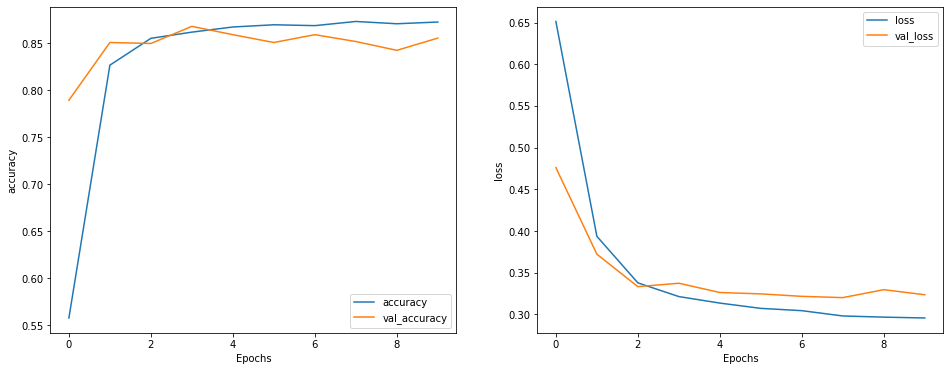

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')